In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import dotenv

2024-11-24 18:59:56.404186: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128  # Reduced batch size for multi-task learning
IMAGE_SIZE = 128

### Import Dataset

In [3]:
# Dataset paths
dataset_path = os.path.join(os.environ['SEGMENTATION_DATASET_PATH'], 'kaggle_3m')
data_csv_path = os.path.join(dataset_path, 'data.csv')

# Load patient data
patient_data = pd.read_csv(data_csv_path)

# Initialize lists to store images and masks for the dataset
images = []
masks = []
patient_ids = []

# Loop over each folder (patient case) in the dataset to load images and corresponding masks
case_folders = sorted(os.listdir(dataset_path))
for folder in case_folders:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-directory files

    # Extract the patient ID from the folder
    patient_id = folder  # Folder name represents the patient ID

    # List image and mask files in the folder
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif') and '_mask' not in f])
    mask_files = sorted([f for f in os.listdir(folder_path) if f.endswith('_mask.tif')])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(folder_path, img_file)
        mask_path = os.path.join(folder_path, mask_file)

        # Read the image (3-channel TIFF)
        img = tiff.imread(img_path)
        
        # Handle missing channels by repeating the FLAIR sequence if needed
        if img.shape[-1] < 3:
            img = np.repeat(img[..., :1], 3, axis=-1)  # Repeat FLAIR if missing sequences

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        # Read the mask (1-channel TIFF)
        mask = tiff.imread(mask_path)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = mask.astype(np.uint8)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        # Append image and mask
        images.append(img)
        masks.append(mask)

        # Append patient ID
        patient_ids.append(patient_id)

In [4]:
# Convert lists to numpy arrays after appending all images and masks
images = np.array(images)
masks = np.array(masks)
patient_ids = np.array(patient_ids)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Normalize the masks
masks = masks.astype('float32') / 255.0

# Split the dataset into training, validation, and testing sets (70% training, 15% validation, 15% testing)
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, temp_idx = next(gss.split(images, masks, groups=patient_ids))

X_train, X_temp = images[train_idx], images[temp_idx]
y_train, y_temp = masks[train_idx], masks[temp_idx]
patient_ids_temp = patient_ids[temp_idx]

# Split the remaining data into validation and testing sets (50% each of the remaining 30%)
gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(gss.split(X_temp, y_temp, groups=patient_ids_temp))

X_val, X_test = X_temp[val_idx], X_temp[test_idx]
y_val, y_test = y_temp[val_idx], y_temp[test_idx]

In [5]:
# Define the U-Net model for segmentation
def unet_segmentation_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Segmentation output
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(c9)

    model = Model(inputs=[inputs], outputs=[segmentation_output])
    return model

In [6]:
# Create the U-Net segmentation model
model = unet_segmentation_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [7]:
# Train the model using the training data
history = model.fit(
    X_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val)
)


Epoch 1/50


I0000 00:00:1732492811.745347  164756 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 44s 2s/step - loss: 0.5455 - accuracy: 0.9632 - val_loss: 0.2275 - val_accuracy: 0.9879
Epoch 2/50
22/22 [==============================] - 39s 2s/step - loss: 0.1417 - accuracy: 0.9903 - val_loss: 0.0841 - val_accuracy: 0.9879
Epoch 3/50
22/22 [==============================] - 41s 2s/step - loss: 0.0471 - accuracy: 0.9903 - val_loss: 0.0449 - val_accuracy: 0.9879
Epoch 4/50
22/22 [==============================] - 39s 2s/step - loss: 0.0369 - accuracy: 0.9903 - val_loss: 0.0431 - val_accuracy: 0.9879
Epoch 5/50
22/22 [==============================] - 39s 2s/step - loss: 0.0340 - accuracy: 0.9903 - val_loss: 0.0415 - val_accuracy: 0.9879
Epoch 6/50
22/22 [==============================] - 39s 2s/step - loss: 0.0316 - accuracy: 0.9903 - val_loss: 0.0445 - val_accuracy: 0.9879
Epoch 7/50
22/22 [==============================] - 39s 2s/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0428 - val_accuracy: 0.9879
Epoch 8/50
22/22 [=============

In [8]:
# Save Model Output
model.save('segmentation_model.h5')

# Save the model history to a file
with open('segmentation_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


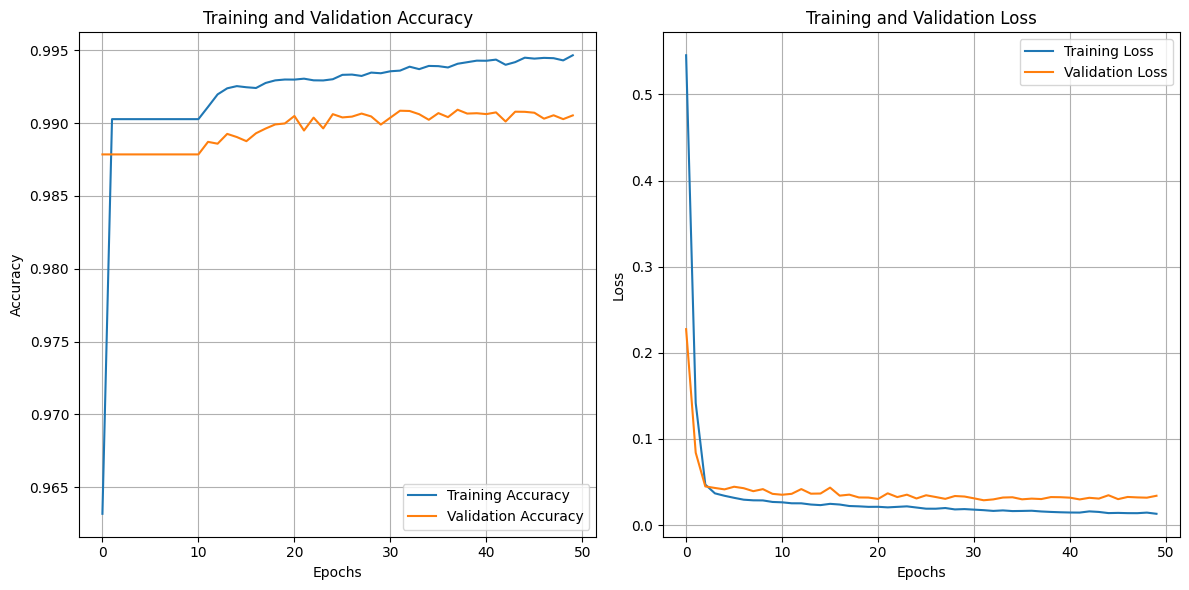

19/19 [==============================] - 1s 74ms/step - loss: 0.0390 - accuracy: 0.9883
Testing Loss: 0.03898884356021881, Testing Accuracy: 0.9883095622062683


In [9]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_results = model.evaluate(X_test, y_test)
print(f"Testing Loss: {test_results[0]}, Testing Accuracy: {test_results[1]}")

1/1 [==============================] - 0s 14ms/step


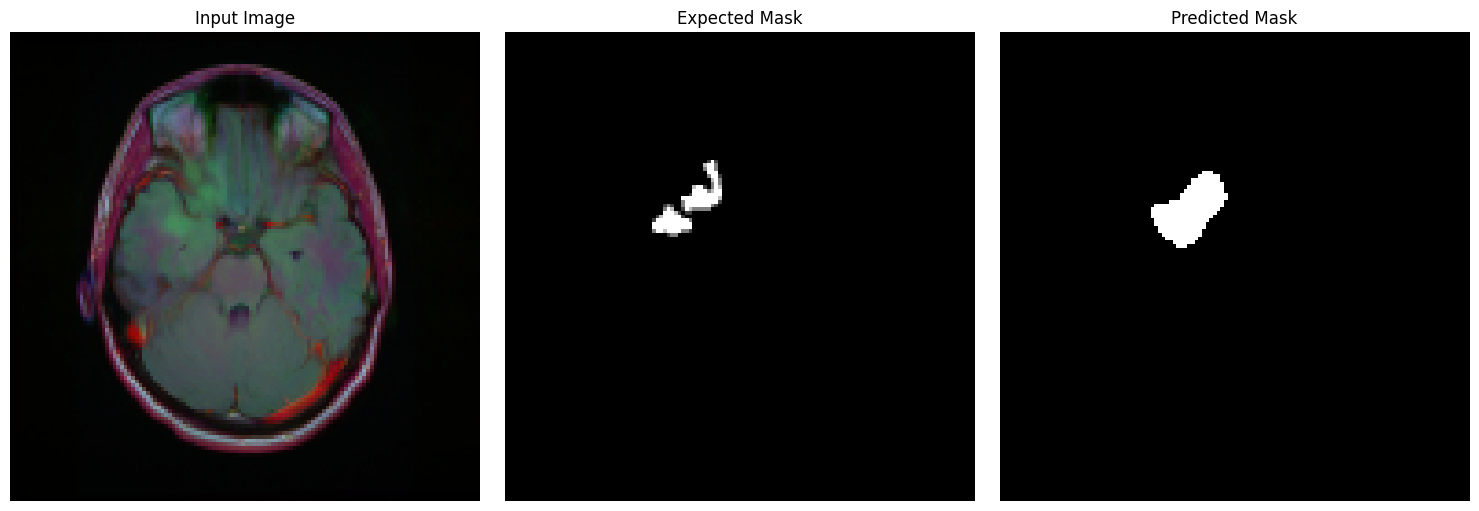

In [16]:
# Function to test the model on PNG or other images
def test_image_segmentation_only(model, image_path, image_mask_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path)
    img2 = cv2.imread(image_mask_path)

    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension

    img2 = cv2.resize(img2, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img2 = img2.astype('float32') / 255.0  # Normalize
    img2 = img2.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the segmentation mask
    segmentation_pred = model.predict(img)
    predicted_mask = (segmentation_pred > 0.5).astype(np.uint8)  # Threshold the output to get binary mask

    # Plot the input image, expected mask, and predicted mask
    plt.figure(figsize=(15, 5))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(img[0, :, :, :], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Expected mask
    plt.subplot(1, 3, 2)
    plt.imshow(img2[0, :, :, :], cmap='gray')
    plt.title('Expected Mask')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for PNG or other images
test_image_path = os.path.join(os.environ['SEGMENTATION_DATASET_PATH'], 'kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_7.tif')
test_image_mask_path = os.path.join(os.environ['SEGMENTATION_DATASET_PATH'], 'kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_7_mask.tif')

test_image_segmentation_only(model, test_image_path, test_image_mask_path)
